# TAHAP 3 : **Program Untuk Pelatihan dan Evaluasi Data**

Program ini memuat file CSV per-urutan (pose + tangan), menambahkan padding/memotong urutan ke fixed length, proses training pengklasifikasi BiLSTM, dan menghasilkan output evaluasi penelitian (akurasi Top-K, macro metrics dan confusion matrix).

- Untuk menjalankan block program masing-masing, tekan *shift* + *enter* atau klik tombol icon '*Play*' ▶︎.
- <b>JALANKAN SETIAP BLOK PROGRAM SECARA SEKUENSIAL!</b>
- Konten di dalam program ini bisa digunakan sebagai panduan tutorial.

## **x.1 Setup and Reproducibility**


#### x.1.1 Import Libraries

In [1]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### x.1.2 Device and Seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Determinism (recommended for research reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Device: cpu


## **x.2 Dataset Configuration and Utilities**


#### x.2.1 Dataset Config

Lakukan penyesuaian path folder pada *csv_folder* sesuai dengan nama folder yang berisi data CSV yang telah diekstrak.

In [ ]:
# === CONFIG ===
csv_folder = Path("csv/")  # change if needed
pad_len = 83
n_features = 118

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

#### x.2.2 Filename Parsing

In [4]:
def parse_label_from_filename(csv_path: Path) -> str:
    stem = csv_path.stem
    parts = stem.split("_")
    if len(parts) < 2:
        return stem
    return "_".join(parts[:-1])


#### x.2.3 Padding/truncation

In [5]:
def pad_or_truncate_with_length(sequence_2d: np.ndarray, target_len: int, n_features: int):
    T, F = sequence_2d.shape
    if F != n_features:
        raise ValueError(f"Expected {n_features} features, but got {F}")

    length = min(T, target_len)

    X = np.zeros((target_len, F), dtype=np.float32)
    X[:length, :] = sequence_2d[:length, :].astype(np.float32)

    return X, length


## **x.3 Dataset Indexing and DataLoaders**

#### x.3.1 Build file index

In [6]:
def build_file_index(csv_folder: Path):
    file_paths = sorted(csv_folder.glob("*.csv"))
    if len(file_paths) == 0:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")

    labels = [parse_label_from_filename(p) for p in file_paths]

    unique_labels = sorted(set(labels))
    label_to_id = {lab: i for i, lab in enumerate(unique_labels)}
    id_to_label = {i: lab for lab, i in label_to_id.items()}

    return file_paths, labels, label_to_id, id_to_label


In [7]:
file_paths, labels, label_to_id, id_to_label = build_file_index(csv_folder)

print("Total sequences:", len(file_paths))
print("Total classes  :", len(label_to_id))
print("Example labels :", list(label_to_id.keys())[:10])


Total sequences: 21711
Total classes  : 1331
Example labels : ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18']


#### x.3.2 Train/Val/Test split


Ubah nilai data splitting jika perlu.
- *train_ratio* (data latih), nilai default 0.8 (80%)
- *test_ratio* (data uji), nilai default 0.1 (10%)
- *val_ratio* (data validasi), nilai default 0.1 (10%)

In [ ]:
def stratified_split(file_paths, labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42): # Ubah nilai sesuai kebutuhan
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = np.random.default_rng(seed)

    label_to_indices = defaultdict(list)
    for i, lab in enumerate(labels):
        label_to_indices[lab].append(i)

    train_idx, val_idx, test_idx = [], [], []

    for lab, idxs in label_to_indices.items():
        idxs = np.array(idxs)
        rng.shuffle(idxs)

        n = len(idxs)
        n_train = int(round(n * train_ratio))
        n_val = int(round(n * val_ratio))
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train].tolist())
        val_idx.extend(idxs[n_train:n_train + n_val].tolist())
        test_idx.extend(idxs[n_train + n_val:].tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    return {"train": train_idx, "val": val_idx, "test": test_idx}


In [9]:
splits = stratified_split(
    file_paths, labels,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    seed=42
)

print("Train:", len(splits["train"]))
print("Val  :", len(splits["val"]))
print("Test :", len(splits["test"]))


Train: 17849
Val  : 1932
Test : 1930


#### x.3.3 PyTorch Dataset

In [10]:
class SignCSVDataset(Dataset):
    def __init__(self, file_paths, labels, label_to_id, pad_len, n_features=118):
        self.file_paths = file_paths
        self.labels = labels
        self.label_to_id = label_to_id
        self.pad_len = pad_len
        self.n_features = n_features

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        csv_path = self.file_paths[idx]
        label_str = self.labels[idx]
        y = self.label_to_id[label_str]

        df = pd.read_csv(csv_path)
        seq = df.values

        X_np, length = pad_or_truncate_with_length(seq, self.pad_len, self.n_features)

        X = torch.from_numpy(X_np)
        y = torch.tensor(y, dtype=torch.long)
        length = torch.tensor(length, dtype=torch.long)

        return X, y, length, csv_path.name


#### x.3.4 Collate Function

In [11]:
def collate_fn(batch):
    X_list, y_list, length_list, fname_list = zip(*batch)

    X_batch = torch.stack(X_list, dim=0)
    y_batch = torch.stack(y_list, dim=0)
    lengths = torch.stack(length_list, dim=0)

    return X_batch, y_batch, lengths, list(fname_list)

In [12]:
train_paths = [file_paths[i] for i in splits["train"]]
train_labels = [labels[i] for i in splits["train"]]

val_paths = [file_paths[i] for i in splits["val"]]
val_labels = [labels[i] for i in splits["val"]]

test_paths = [file_paths[i] for i in splits["test"]]
test_labels = [labels[i] for i in splits["test"]]

train_dataset = SignCSVDataset(train_paths, train_labels, label_to_id, pad_len, n_features)
val_dataset   = SignCSVDataset(val_paths,   val_labels,   label_to_id, pad_len, n_features)
test_dataset  = SignCSVDataset(test_paths,  test_labels,  label_to_id, pad_len, n_features)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))


Train batches: 279
Val batches  : 31
Test batches : 31


In [13]:
Xb, yb, lengths, fnames = next(iter(train_loader))

print("Xb shape:", Xb.shape)
print("yb shape:", yb.shape)
print("lengths min/max:", int(lengths.min()), int(lengths.max()))
print("Example:", fnames[0], "-> class", int(yb[0]), "label", id_to_label[int(yb[0])])


Xb shape: torch.Size([64, 83, 118])
yb shape: torch.Size([64])
lengths min/max: 11 83
Example: w_097.csv -> class 1325 label w


## 5) Model — BiLSTM with Masked Mean Pooling


In [14]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, X, lengths):
        out, _ = self.lstm(X)

        B, T, D = out.shape

        mask = torch.arange(T, device=out.device).unsqueeze(0) < lengths.unsqueeze(1)
        mask_f = mask.float().unsqueeze(-1)

        summed = (out * mask_f).sum(dim=1)
        denom = lengths.clamp(min=1).unsqueeze(1).float()

        feat = summed / denom
        logits = self.classifier(feat)
        return logits


## 6) Training Utilities


In [15]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()


In [16]:
def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for Xb, yb, lengths, fnames in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        lengths = lengths.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits = model(Xb, lengths)
            loss = loss_fn(logits, yb)
            acc = accuracy_from_logits(logits, yb)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 7) Train


In [17]:
num_classes = len(label_to_id)

model = BiLSTMClassifier(
    input_size=n_features,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model params:", sum(p.numel() for p in model.parameters()))


Model params: 853811


Blok program dibawah merupakan proses inti pelatihan/training data. Waktu yang dihabiskan diperkirakan cukup lama tergantung dari spesifikasi perangkat PC atau parameter epoch yang digunakan. 

In [18]:
epochs = 60

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader, optimizer=None)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")


Epoch 01 | train loss 5.1125 acc 0.0245 | val loss 4.0671 acc 0.0596
Epoch 02 | train loss 4.2154 acc 0.0694 | val loss 3.3522 acc 0.1221
Epoch 03 | train loss 3.3917 acc 0.1473 | val loss 2.3522 acc 0.2641
Epoch 04 | train loss 2.6662 acc 0.2517 | val loss 1.7716 acc 0.3873
Epoch 05 | train loss 2.3242 acc 0.3308 | val loss 1.5134 acc 0.4612
Epoch 06 | train loss 1.9332 acc 0.4186 | val loss 1.1600 acc 0.5892
Epoch 07 | train loss 1.6438 acc 0.4888 | val loss 0.9822 acc 0.6507
Epoch 08 | train loss 1.4619 acc 0.5388 | val loss 0.9968 acc 0.6442
Epoch 09 | train loss 1.2959 acc 0.5855 | val loss 0.7455 acc 0.7295
Epoch 10 | train loss 1.1941 acc 0.6126 | val loss 0.8135 acc 0.7021
Epoch 11 | train loss 1.0686 acc 0.6483 | val loss 0.6685 acc 0.7524
Epoch 12 | train loss 0.9953 acc 0.6732 | val loss 0.6063 acc 0.7930
Epoch 13 | train loss 0.9100 acc 0.7018 | val loss 0.5129 acc 0.8216
Epoch 14 | train loss 0.8487 acc 0.7219 | val loss 0.5383 acc 0.8135
Epoch 15 | train loss 0.7797 acc 0

Program di bawah adalah proses save dan penyimpanan model yang telah di latih di dalam folder trained_models/ dalam bentuk file '.pt'.
- Contohnya, secara default : *best_lstm.pt* (bisa diganti sesuai keinginan dengan merubah *"trained_model/best_lstm.pt"*)

In [ ]:
from pathlib import Path
import torch

def save_checkpoint(path, model, label_to_id, id_to_label, pad_len, n_features,
                    hidden_size=128, num_layers=2, dropout=0.2):
    """
    Saves everything needed for external validation / inference:
    - model weights
    - label mapping
    - padding length & feature dim
    - model hyperparams (so you can reconstruct the model later)
    """
    ckpt = {
        "state_dict": model.state_dict(),
        "label_to_id": label_to_id,
        "id_to_label": id_to_label,
        "pad_len": int(pad_len),
        "n_features": int(n_features),
        "hidden_size": int(hidden_size),
        "num_layers": int(num_layers),
        "dropout": float(dropout),
    }
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(ckpt, path)
    print(f"[SAVED] checkpoint -> {path.resolve()}")

# Example usage (match your model settings):
save_checkpoint(
    "trained_model/best_lstm.pt",
    model=model,
    label_to_id=label_to_id,
    id_to_label=id_to_label,
    pad_len=pad_len,          # 83
    n_features=n_features,    # 118
    hidden_size=128,
    num_layers=2,
    dropout=0.2
)


[SAVED] checkpoint -> D:\Projects\Python\SIBIFullBody312 (cleaned)\checkpoints\best_lstm.pt


## 8) Research-Grade Evaluation (Top-k, Macro/Micro, Confusion Matrix)


In [29]:
@torch.no_grad()
def evaluate_collect_predictions(model, loader, device, k_list=(1, 3, 5)):
    model.eval()

    all_true = []
    all_pred = []
    all_prob = []

    correct_topk = {k: 0 for k in k_list}
    total = 0

    for Xb, yb, lengths, fnames in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        lengths = lengths.to(device)

        logits = model(Xb, lengths)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)

        for k in k_list:
            topk = torch.topk(prob, k=k, dim=1).indices
            correct_topk[k] += (topk == yb.unsqueeze(1)).any(dim=1).sum().item()

        all_true.append(yb.cpu())
        all_pred.append(pred.cpu())
        all_prob.append(prob.cpu())

        total += yb.size(0)

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    y_prob = torch.cat(all_prob).numpy()

    topk_acc = {f"top{k}": correct_topk[k] / total for k in k_list}
    return y_true, y_pred, y_prob, topk_acc


In [30]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm


In [31]:
def safe_classification_report(y_true, y_pred, y_prob=None, target_names=None):
    import numpy as np

    summary_metrics = {
        "accuracy": float((y_true == y_pred).mean())
    }

    report_text = ""
    per_class_df = None

    try:
        import pandas as pd
        from sklearn.metrics import (
            classification_report,
            precision_score, recall_score, f1_score,
            balanced_accuracy_score,
            matthews_corrcoef,
            cohen_kappa_score,
            log_loss
        )

        # 🔹 FIX IS HERE
        unique_labels = np.unique(y_true)

        aligned_target_names = [
            target_names[int(i)] for i in unique_labels
        ]

        report_text = classification_report(
            y_true,
            y_pred,
            labels=unique_labels,               # ✅ IMPORTANT
            target_names=aligned_target_names,  # ✅ MATCHED
            digits=4,
            zero_division=0
        )

        summary_metrics.update({
            "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),

            "macro_precision": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
            "macro_recall": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
            "macro_f1": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),

            "micro_precision": float(precision_score(y_true, y_pred, average="micro", zero_division=0)),
            "micro_recall": float(recall_score(y_true, y_pred, average="micro", zero_division=0)),
            "micro_f1": float(f1_score(y_true, y_pred, average="micro", zero_division=0)),

            "weighted_precision": float(precision_score(y_true, y_pred, average="weighted", zero_division=0)),
            "weighted_recall": float(recall_score(y_true, y_pred, average="weighted", zero_division=0)),
            "weighted_f1": float(f1_score(y_true, y_pred, average="weighted", zero_division=0)),

            "mcc": float(matthews_corrcoef(y_true, y_pred)),
            "cohen_kappa": float(cohen_kappa_score(y_true, y_pred)),
        })

        if y_prob is not None:
            C = y_prob.shape[1]
            summary_metrics["log_loss"] = float(
                log_loss(y_true, y_prob, labels=list(range(C)))
            )

        cr_dict = classification_report(
            y_true, y_pred,
            labels=unique_labels,
            target_names=aligned_target_names,
            output_dict=True,
            zero_division=0
        )

        class_rows = {}
        for k, v in cr_dict.items():
            if k in ["accuracy", "macro avg", "weighted avg"]:
                continue
            class_rows[k] = v

        per_class_df = pd.DataFrame(class_rows).T

    except Exception as e:
        report_text = f"[Metric computation failed] {e}"

    return report_text, summary_metrics, per_class_df




In [32]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix"):
    cm_plot = cm.astype(np.float64)

    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_plot)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    n = len(class_names)
    step = max(1, n // 30)
    tick_positions = np.arange(0, n, step)

    plt.xticks(tick_positions, [class_names[i] for i in tick_positions], rotation=90)
    plt.yticks(tick_positions, [class_names[i] for i in tick_positions])

    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 9) Run Evaluation & Save Outputs


Blok program dibawah berfungsi untuk menampilkan output rangkuman hasil training dengan beberapa metrik, seperti :
- General accuracy, macro, micro, confusion matrix, dll.

Classes evaluated: 184

=== SUMMARY METRICS ===
accuracy: 0.9047
balanced_accuracy: 0.6225
macro_precision: 0.4643
macro_recall: 0.4582
macro_f1: 0.4591
micro_precision: 0.9047
micro_recall: 0.9047
micro_f1: 0.9047
weighted_precision: 0.9121
weighted_recall: 0.9047
weighted_f1: 0.9040
mcc: 0.9037
cohen_kappa: 0.9036
log_loss: 0.3363

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           1     0.8462    1.0000    0.9167        22
          10     1.0000    0.9091    0.9524        22
          11     1.0000    0.9444    0.9714        18
          12     0.9474    1.0000    0.9730        18
          13     1.0000    0.8333    0.9091        18
          14     1.0000    0.9444    0.9714        18
          15     0.8571    1.0000    0.9231        18
          16     0.8571    1.0000    0.9231        18
          17     1.0000    0.9444    0.9714        18
          18     0.8571    1.0000    0.9231        18
          19     0.8750    0.7778    0.

c:\Users\Lenovo\anaconda3\envs\SIBI_LSTMTrainer312\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,precision,recall,f1-score,support
1,0.846154,1.000000,0.916667,22.0
10,1.000000,0.909091,0.952381,22.0
11,1.000000,0.944444,0.971429,18.0
12,0.947368,1.000000,0.972973,18.0
13,1.000000,0.833333,0.909091,18.0
14,1.000000,0.944444,0.971429,18.0
15,0.857143,1.000000,0.923077,18.0
16,0.857143,1.000000,0.923077,18.0
17,1.000000,0.944444,0.971429,18.0
18,0.857143,1.000000,0.923077,18.0


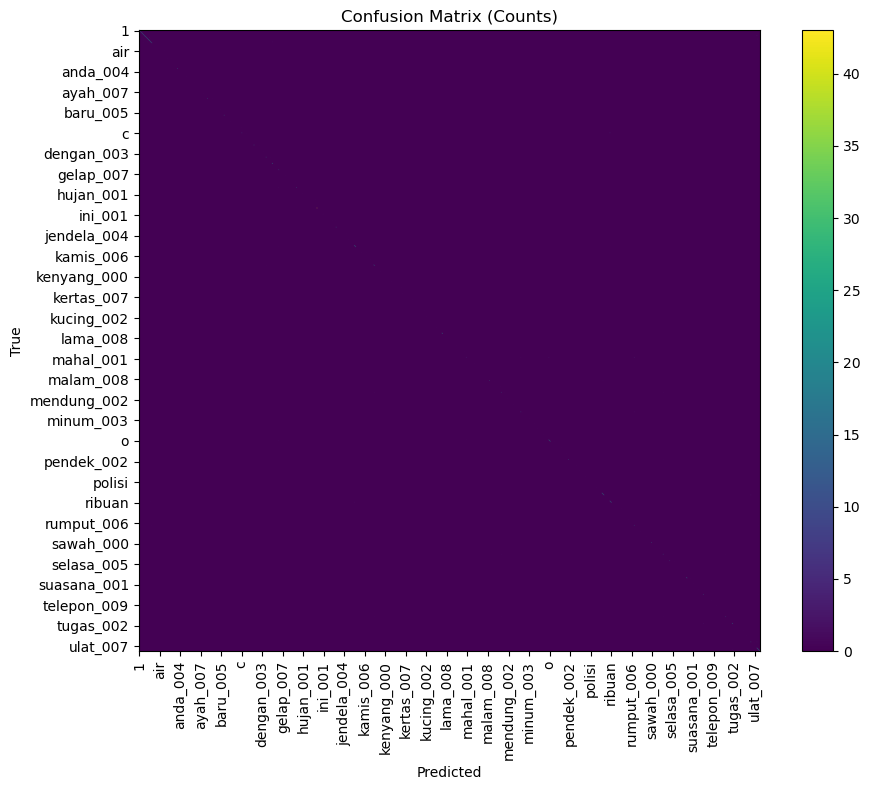

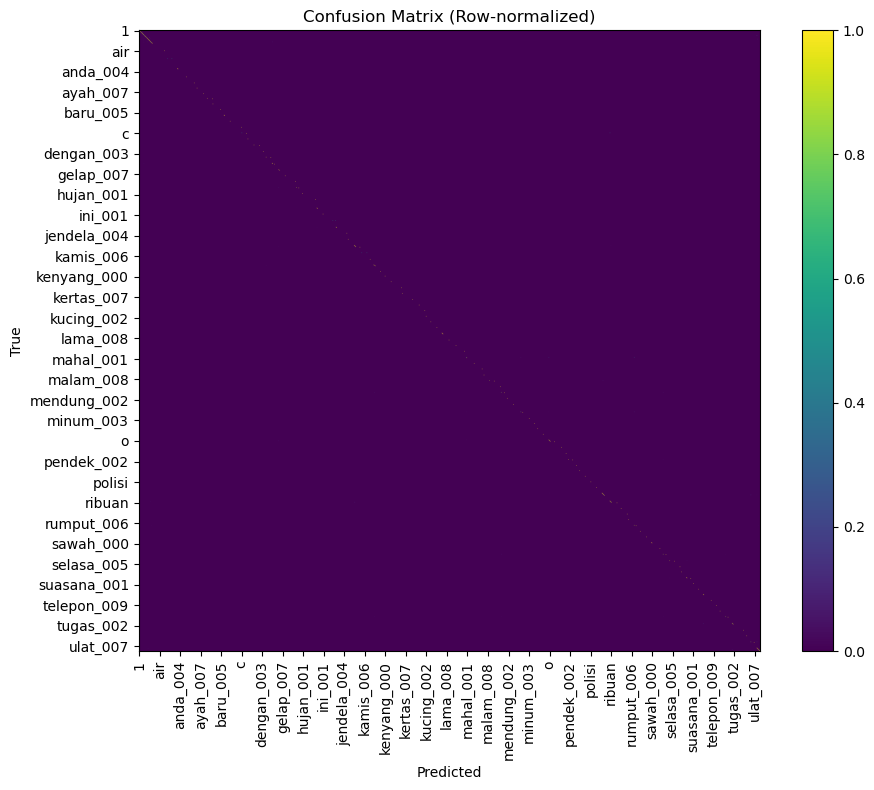

In [33]:
eval_loader = test_loader  # switch to val_loader if preferred

class_names = [id_to_label[i] for i in range(num_classes)]

y_true, y_pred, y_prob, topk_acc = evaluate_collect_predictions(
    model, eval_loader, device, k_list=(1, 3, 5)
)

cm = compute_confusion_matrix(y_true, y_pred, num_classes)
report_text, metrics, per_class_df = safe_classification_report(
    y_true, y_pred, y_prob=y_prob, target_names=class_names
)

print("Classes evaluated:", len(np.unique(y_true)))

print("\n=== SUMMARY METRICS ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(report_text)

# Optional: show per-class metrics table (first 10 rows)
if per_class_df is not None:
    display(per_class_df.head(10))

plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix (Row-normalized)")


Blok program dibawah berfungsi untuk menyimpan hasil evaluasi ke dalam folder results_eval/ sesuai format metriknya masing-masing.

In [34]:
import json

results_dir = Path("results_eval/")
results_dir.mkdir(parents=True, exist_ok=True)

np.save(results_dir / "confusion_matrix_counts.npy", cm)
np.save(results_dir / "y_true.npy", y_true)
np.save(results_dir / "y_pred.npy", y_pred)
np.save(results_dir / "y_prob.npy", y_prob)

summary = {
    "num_sequences_evaluated": int(len(y_true)),
    "num_classes": int(num_classes),
    "topk_acc": {k: float(v) for k, v in topk_acc.items()},
    "metrics": {k: float(v) for k, v in metrics.items()},
    "pad_len": int(pad_len),
    "features_per_frame": int(n_features),
    "seed": 42,
    "train_ratio": float(train_ratio),
    "val_ratio": float(val_ratio),
    "test_ratio": float(test_ratio),
}

with open(results_dir / "summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

with open(results_dir / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report_text)

if per_class_df is not None:
    per_class_df.to_csv(results_dir / "per_class_metrics.csv", index=True)
    print("[SAVED] per_class_metrics.csv")

print("[SAVED] Evaluation outputs in:", results_dir.resolve())


[SAVED] per_class_metrics.csv
[SAVED] Evaluation outputs in: D:\Projects\Python\SIBIFullBody312 (cleaned)\results_eval


In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.styles import Font, Alignment
from openpyxl.utils import get_column_letter


def export_confusion_matrix_to_excel_colorized(
    y_true,
    y_pred,
    target_names,
    out_path,
    include_col_normalized=True,
    cmap_mode="excel_3color"
):
    """
    Writes confusion matrix to Excel and colorizes numeric cells with conditional formatting.

    Sheets:
      - cm_counts
      - cm_row_normalized
      - (optional) cm_col_normalized

    Notes:
      - Uses only labels present in y_true to keep matrix size reasonable and aligned.
      - 'target_names' must be a list mapping class_id -> label string.
    """
    # ---- build matrices ----
    unique_labels = np.unique(y_true)
    labels_text = [target_names[int(i)] for i in unique_labels]

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    df_counts = pd.DataFrame(cm, index=labels_text, columns=labels_text)

    row_sums = cm.sum(axis=1, keepdims=True)
    cm_row = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)
    df_row = pd.DataFrame(cm_row, index=labels_text, columns=labels_text)

    df_col = None
    if include_col_normalized:
        col_sums = cm.sum(axis=0, keepdims=True)
        cm_col = np.divide(cm, col_sums, out=np.zeros_like(cm, dtype=float), where=col_sums != 0)
        df_col = pd.DataFrame(cm_col, index=labels_text, columns=labels_text)

    out_path = str(out_path)

    # ---- write with pandas ----
    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        df_counts.to_excel(writer, sheet_name="cm_counts")
        df_row.to_excel(writer, sheet_name="cm_row_normalized")
        if df_col is not None:
            df_col.to_excel(writer, sheet_name="cm_col_normalized")

        wb = writer.book

        # ---- conditional formatting rules ----
        # 3-color scale similar to typical heatmaps: low=white, mid=light yellow, high=red/green
        # You can switch color direction by adjusting the RGB values.
        if cmap_mode == "excel_3color":
            # White -> Light Yellow -> Red (good for counts)
            rule_counts = ColorScaleRule(
                start_type="min", start_value=0, start_color="FFFFFF",
                mid_type="percentile", mid_value=50, mid_color="FFF2CC",
                end_type="max", end_value=0, end_color="F8696B"
            )
            # White -> Light Green -> Dark Green (good for normalized)
            rule_norm = ColorScaleRule(
                start_type="num", start_value=0, start_color="FFFFFF",
                mid_type="num", mid_value=0.5, mid_color="C6EFCE",
                end_type="num", end_value=1.0, end_color="006100"
            )
        else:
            # Fallback: simple 2-color (white -> blue)
            rule_counts = ColorScaleRule(
                start_type="min", start_value=0, start_color="FFFFFF",
                end_type="max", end_value=0, end_color="4F81BD"
            )
            rule_norm = ColorScaleRule(
                start_type="num", start_value=0, start_color="FFFFFF",
                end_type="num", end_value=1.0, end_color="4F81BD"
            )

        def style_sheet(ws, is_normalized=False):
            # Freeze headers
            ws.freeze_panes = "B2"

            # Bold header row/col
            header_font = Font(bold=True)
            for cell in ws[1]:
                cell.font = header_font
                cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)
            for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
                for cell in row:
                    cell.font = header_font
                    cell.alignment = Alignment(horizontal="left", vertical="center", wrap_text=True)

            # Format numbers
            if is_normalized:
                # show as percentages with 2 decimals
                for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=2, max_col=ws.max_column):
                    for cell in row:
                        cell.number_format = "0.00%"
            else:
                # integer format for counts
                for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=2, max_col=ws.max_column):
                    for cell in row:
                        cell.number_format = "0"

            # Make columns narrower for large matrices (optional tweak)
            # Column A is label column—make it wider.
            ws.column_dimensions["A"].width = 20
            for c in range(2, ws.max_column + 1):
                col_letter = get_column_letter(c)
                ws.column_dimensions[col_letter].width = 4  # small square-ish cells

            # Apply conditional formatting to numeric area (B2 ... last cell)
            start_cell = "B2"
            end_cell = f"{get_column_letter(ws.max_column)}{ws.max_row}"
            data_range = f"{start_cell}:{end_cell}"

            ws.conditional_formatting.add(data_range, rule_norm if is_normalized else rule_counts)

        # Style each sheet
        style_sheet(wb["cm_counts"], is_normalized=False)
        style_sheet(wb["cm_row_normalized"], is_normalized=True)
        if include_col_normalized and "cm_col_normalized" in wb.sheetnames:
            style_sheet(wb["cm_col_normalized"], is_normalized=True)

    return out_path, len(unique_labels), int(cm.sum())


# ---- USAGE ----
cm_xlsx_path = results_dir / "confusion_matrix_colorized.xlsx"

saved_path, n_classes, n_samples = export_confusion_matrix_to_excel_colorized(
    y_true=y_true,
    y_pred=y_pred,
    target_names=id_to_label,   # must be list: id -> label
    out_path=cm_xlsx_path,
    include_col_normalized=True
)

print(f"[SAVED] Colorized confusion matrix: {saved_path}")
print(f"Classes in matrix: {n_classes}, total samples: {n_samples}")


[SAVED] Colorized confusion matrix: results_eval\confusion_matrix_colorized.xlsx
Classes in matrix: 184, total samples: 1864
